## Non-Gaussian Segmentation on HI simulations

In [2]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


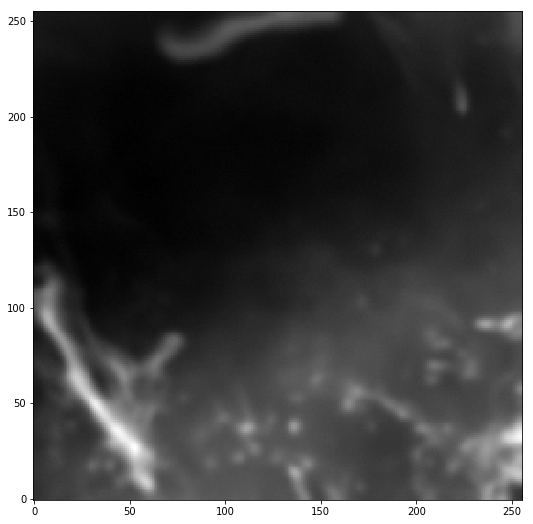

In [42]:
HDU = fits.open("/Users/robitaij/postdoc/eleonore/Tb_reso_0.8km.s-1_noise_0.05K_256_beam_0_2_2_AM.fits")
cube = HDU[0].data
cdens = np.sum(cube,axis=0)
fits.writeto('/Users/robitaij/postdoc/eleonore/simu_cdens.fits',\
            cdens,overwrite=True)

figure(figsize=(9,9))
imshow(cdens, origin='below', cmap='gray')

In [14]:
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from gauss_beam import gauss_beam

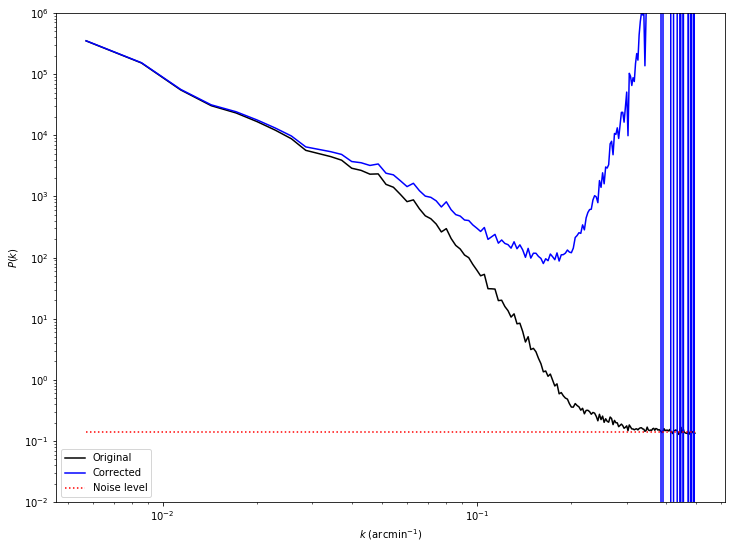

In [118]:
na = cdens.shape[1]
nb = cdens.shape[0]
cdenszm = cdens - np.mean(cdens)

#Apodization
tapper = apodize(nb,na,0.97)
cdenst = cdenszm *tapper
cdensr = padding(cdenst,350,350)

beam = gauss_beam(2.,350,350,FWHM=False)
tab_k, spec_beam = powspec(beam, reso=1)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

#Fourier power spectrum
tab_k, spec_k = powspec(cdensr, reso=1)

Noise = mean(spec_k[(tab_k >=0.4) & (tab_k<=0.5)])

#Plot Fourier power spectrum
plt.figure(figsize=(12,9))
plt.plot(tab_k[1:], spec_k[1:], color='black',label='Original', linewidth=1.5)
plt.plot(tab_k[1:], (spec_k[1:]-Noise)/spec_beamn[1:], color='blue',label='Corrected', linewidth=1.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylim([10**-2,10**6])
plt.ylabel(r"$P(k)$")
plt.plot([min(tab_k[1:]),max(tab_k[1:])],[Noise,Noise],':',color='red',label='Noise level')
plt.legend()

In [119]:
Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=1, q=0, qdyn=False)
del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[4]

#Set a list of q
q=[]
q=[2.7]*21

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(cdenszm, reso=1, q=q, qdyn=False, skewl=0.4, apodize= 0.97, arrdim = np.array([350,350]), cutpad=True, smooth=False)

#Noise and beam corrections
S1an = np.copy(S1a)
S1an[0,3:] = (S1a[0,3:]-Noise)/BS1an[3:]
S1an[1,3:] = (S1a[1,3:]-Noise)/BS1an[3:]
S1an[2,3:] = (S1a[2,3:]-Noise)/BS1an[3:]

350 350


0.15578364753301274


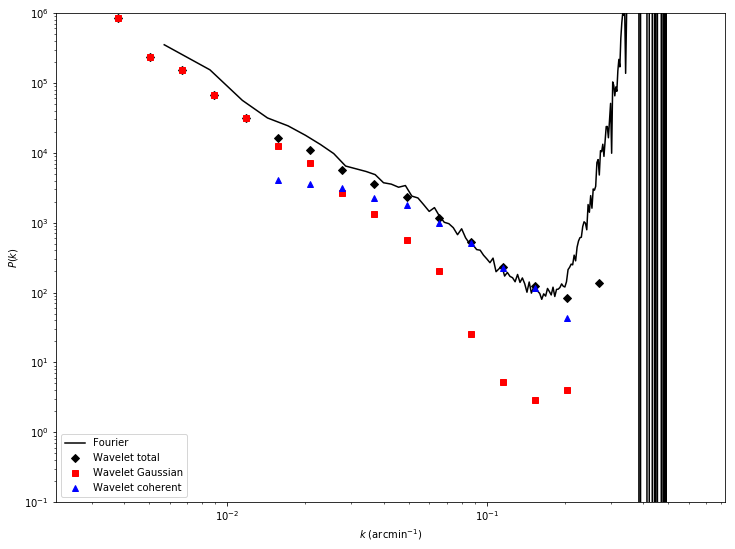

In [120]:
#Plot Fourier power spectrum
plt.figure(figsize=(12,9))
plt.plot(tab_k[1:], (spec_k[1:]-Noise)/spec_beamn[1:], color='black',label='Fourier', linewidth=1.5)
plt.plot(wav_k, S1an[0,:],'D',color='black',label='Wavelet total')
plt.plot(wav_k, S1an[2,:],'s',color='red',label='Wavelet Gaussian')
plt.plot(wav_k, S1an[1,:],'^',color='blue',label='Wavelet coherent')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k$ (arcmin$^{-1}$)")
plt.ylabel(r"$P(k)$")
plt.ylim([10**-1,10**6])
plt.legend()
print mean(spec_k[(tab_k >=0.3) & (tab_k<=0.4)])

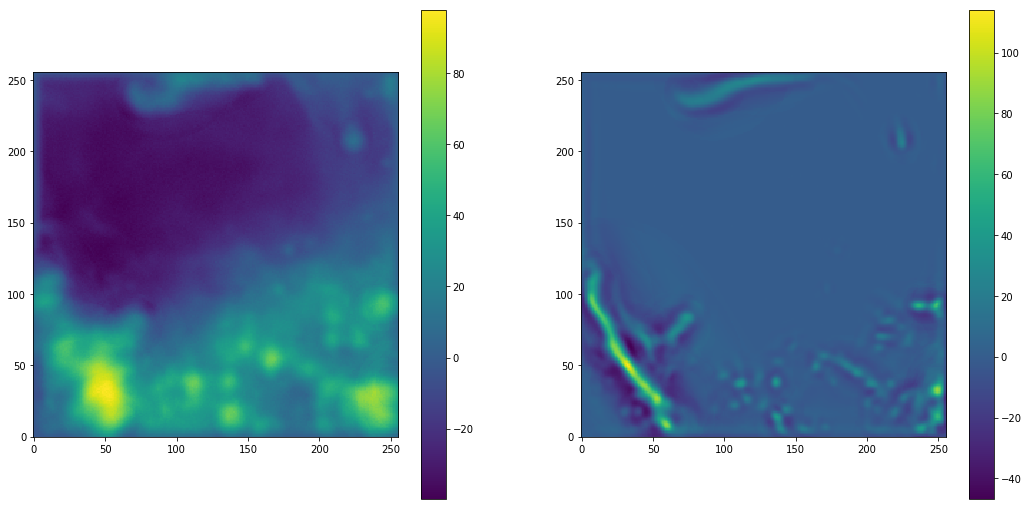

In [113]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/eleonore/simu_coherent.fits',\
            coherent.real,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/eleonore/simu_gaussian.fits',\
            Gaussian.real,overwrite=True)

fig_all = plt.figure(1, figsize=(18,9))

plt.subplot(1,2,1)
imshow(Gaussian.real,origin='below')
plt.colorbar()

plt.subplot(1,2,2)
imshow(coherent.real,origin='below')
plt.colorbar()